#DATASCI W261: Machine Learning at Scale

##Linear regresssion through gradient desecnt method

# Data Generation

Data Information:
+ Sizes: 1000 points
+ True model: y = 1.0 * x - 4
+ Noise：Normal Distributed mean = 0, var = 0.5

In [1]:
 %matplotlib inline
import numpy as np
import pylab 
size = 1000
x = np.random.uniform(-4, 4, size)
y = x * 1.0 - 4 + np.random.normal(0,0.5,size)
data = zip(y,x)
np.savetxt('LinearRegression.csv',data,delimiter = ",")

# Data Visualiazation

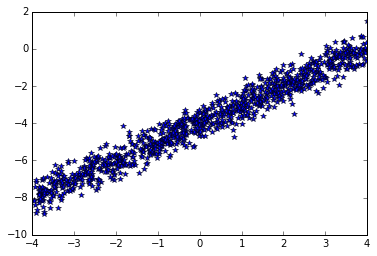

In [2]:
pylab.plot(x, y,'*')
pylab.show()

# MrJob class Code 

Objective function:
$ Q_{ui} = \cases{
r &  if user u rate item i \cr
0 & if user u did not rate item i
} $

In [18]:
%%writefile MrJobBatchGDUpdate_LinearRegression.py
from mrjob.job import MRJob

# This MrJob calculates the gradient of the entire training set 
#     Mapper: calculate partial gradient for each example  
#     
class MrJobBatchGDUpdate_LinearRegression(MRJob):
    # run before the mapper processes any input

    
    #load linear regession model file
    def read_weightsfile(self):
        # Read weights file
        #recordStrs = [s.split('\n')[0].split('\t') for s in open("model").readlines()]
        with open('weights.txt', 'r') as f:
            self.weights = [float(v) for v in f.readline().split(',')]
        # Initialze gradient for this iteration
        self.partial_Gradient = [0]*len(self.weights)
        self.partial_count = 0
    
        
    # MAPPER Calculate partial gradient for each example 
    def partial_gradient(self, _, line):
        D = (map(float,line.split(',')))
        # y_hat is the predicted value given current weights
        y_hat = self.weights[0]+self.weights[1]*D[1]
        # Update parial gradient vector with gradient form current example
        yield None, ([D[0]-y_hat,(D[0]-y_hat)*D[1]], 1) #partial gradient for b, partial gradient for m, then counter
    
  
        
    # REDUCER Accumulate partial gradient from mapper and emit total gradient 
    # Output: key = None, Value = gradient vector
    def gradient_accumulater(self, _, partial_Gradient_Record): 
        total_gradient = [0]*2
        total_count = 0
        for partial_Gradient, partial_count in partial_Gradient_Record:
            total_count = total_count + partial_count
            total_gradient[0] = total_gradient[0] + partial_Gradient[0]
            total_gradient[1] = total_gradient[1] + partial_Gradient[1]
        yield None, [v/total_count for v in total_gradient]
    
    def steps(self):
        return [self.mr(mapper_init=self.read_weightsfile,
                       mapper=self.partial_gradient,
                       #mapper_final=self.partial_gradient_emit,
                       reducer=self.gradient_accumulater)] 
    

    # Calculate partial gradient for each example 
    def partial_gradient_InMemoryCombiner(self, _, line):
        D = (map(float,line.split(',')))
        # y_hat is the predicted value given current weights
        y_hat = self.weights[0]+self.weights[1]*D[1]
        # Update parial gradient vector with gradient form current example
        self.partial_Gradient =  [self.partial_Gradient[0]+ D[0]-y_hat, self.partial_Gradient[1]+(D[0]-y_hat)*D[1]]
        self.partial_count = self.partial_count + 1
        #yield None, (D[0]-y_hat,(D[0]-y_hat)*D[1],1)
    # Finally emit in-memory partial gradient and partial count
    def partial_gradient_emit(self):
        yield None, (self.partial_Gradient,self.partial_count)
        
     
    
    
if __name__ == '__main__':
    MrJobBatchGDUpdate_LinearRegression.run()

Overwriting MrJobBatchGDUpdate_LinearRegression.py


# Driver Code

**Linear regression via gradient descent**
**Objective Function:**
$$ Minimize (\textbf{Y} - \textbf{X}\beta)^2 $$

**Gradient Function:** 
$$ Minimize 2(\textbf{Y} - \textbf{X}\beta)\textbf{X} $$

In [4]:
!pwd # print the working directory
!ls -l LinearRegression.csv

/Users/z084224/Downloads
-rw-r--r--  1 z084224  DHC\Domain Users  51469 Jul 13 14:30 LinearRegression.csv


In [19]:
%reload_ext autoreload #Need to autoreload module if you change it
%autoreload 2

from numpy import random,array
from MrJobBatchGDUpdate_LinearRegression import MrJobBatchGDUpdate_LinearRegression

learning_rate = 0.05
stop_criteria = 0.000005

# Generate random values as inital weights
weights = array([random.uniform(-3,3),random.uniform(-3,3)])
# Write the weights to the files
with open('weights.txt', 'w') as f:
    f.writelines(','.join(str(j) for j in weights))

# create a mrjob instance for batch gradient descent update over all data
mr_job = MrJobBatchGDUpdate_LinearRegression(args=['LinearRegression.csv', '--file=weights.txt'])
# Update centroids iteratively
i = 0
while(1):
    print "iteration ="+str(i)+"  weights =",weights
    # Save weights from previous iteration
    weights_old = weights
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            # value is the gradient value
            key,value =  mr_job.parse_output_line(line)
            # Update weights
            weights = weights + learning_rate*array(value)
    i = i + 1
    # Write the updated weights to file 
    with open('weights.txt', 'w') as f:
        f.writelines(','.join(str(j) for j in weights))
    # Stop if weights get converged
    if(sum((weights_old-weights)**2)<stop_criteria):
        break
        
print "Final weights\n"
print weights

iteration =0  weights = [-1.43521565  1.35209624]
iteration =1  weights = [-1.56369854  1.25487755]
iteration =2  weights = [-1.6853878   1.18262329]
iteration =3  weights = [-1.800718    1.12902249]
iteration =4  weights = [-1.91007798  1.08935474]
iteration =5  weights = [-2.0138192   1.06008951]
iteration =6  weights = [-2.11226214  1.03858647]
iteration =7  weights = [-2.20570121  1.02287124]
iteration =8  weights = [-2.2944086   1.01146765]
iteration =9  weights = [-2.37863728  1.0032722 ]
iteration =10  weights = [-2.45862338  0.99746018]
iteration =11  weights = [-2.53458808  0.99341541]
iteration =12  weights = [-2.60673918  0.99067766]
iteration =13  weights = [-2.67527232  0.98890339]
iteration =14  weights = [-2.74037206  0.98783628]
iteration =15  weights = [-2.80221275  0.98728524]
iteration =16  weights = [-2.86095932  0.98710796]
iteration =17  weights = [-2.91676789  0.98719857]
iteration =18  weights = [-2.96978637  0.98747848]
iteration =19  weights = [-3.02015499  0.

In [ ]:
!cat  weights.txt

In [12]:
pwd

u'/Users/jshanahan/Dropbox/Projects/Target-2016-04/Classes/Lecture-09-Linear-Regression'

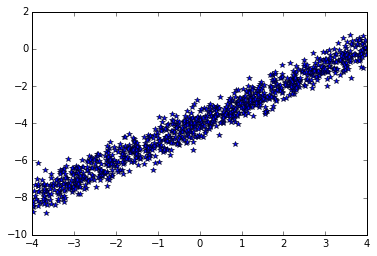

In [20]:
 %matplotlib inline
import numpy as np
import pylab 

size = 1000
x = np.random.uniform(-4, 4, size)
y = x * 1.0 - 4 + np.random.normal(0,0.5,size)
data = zip(y,x)

pylab.plot(x, y,'*')
pylab.show()